In [2]:
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import sys
import os
sys.path.insert(0, "../packages/python")
from data import utils as data_utils
from data import augmentation as data_augmentation
from models import cell_segmentation as segmentators

In [3]:
# Descargar checkpoint de SAM por aca : https://pypi.org/project/segment-anything-py/#model-checkpoints
SAM_CHECKPOINT_PATH = "/media/fast-bucket/models/SAM/sam_vit_h_4b8939.pth"
IMAGE_PATH = "../untracked/datasets/Abril2023/small_debug_dataset/input/"
OUTPUT = "../untracked/datasets/Abril2023/sam_out/"

In [4]:
cmg = segmentators.SAMCellMaskGenerator(SAM_CHECKPOINT_PATH, model_type = 'vit_h', device = 'cpu')


In [5]:
data_utils.dataset_cell_segmentation(cmg, IMAGE_PATH, os.path.join(OUTPUT, "sam_out_2.csv"))

### Tests...

In [11]:
# Read an image 
import cv2 as cv
image_input = cv.imread(os.path.join(IMAGE_PATH, "331.png"))
image_input = cv.cvtColor(image_input, cv.COLOR_BGR2RGB)

mask_gen = cmg.generate(image_input)


In [18]:
mask_gen_f = cmg._filter_masks(mask_gen)

In [24]:
masks_df = cmg._masks_to_df(mask_gen_f, "kakakak")
masks_df

,area,x,y,w,h,bbox_area,image,cell_id
0,15287,2157,499,143,131,18733,kakakak,0
1,18433,268,1277,180,172,30960,kakakak,1
2,18477,330,1671,147,165,24255,kakakak,2
3,21785,2788,1925,201,122,24522,kakakak,3
4,23053,1778,1898,182,149,27118,kakakak,4
...,...,...,...,...,...,...,...,...
111,1314,1644,414,41,40,1640,kakakak,111
112,832,1358,1559,33,31,1023,kakakak,112
113,1694,1660,893,39,59,2301,kakakak,113
114,2950,2483,380,66,58,3828,kakakak,114


In [21]:
mask_gen_f[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 15287,
 'bbox': [2157, 499, 143, 131],
 'predicted_iou': 0.9981080293655396,
 'point_coords': [[2160.0, 544.0]],
 'stability_score': 0.9837746620178223,
 'crop_box': [0, 0, 3072, 2048]}

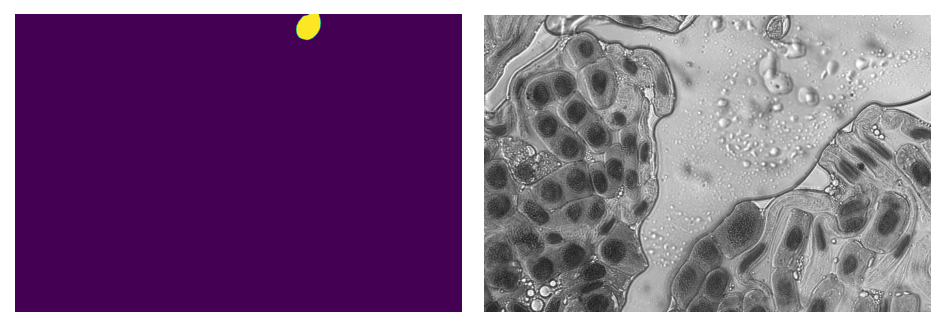

In [23]:

plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(mask_gen_f[10]["segmentation"])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image_input)
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
cmg.generate_all_masks(IMAGE_PATH, CSV_PATH)

In [7]:
data_df = pd.read_csv(CSV_PATH)

In [8]:
data_df

,area,x,y,w,h,bbox_area,image,cell_id
0,34444.0,441,1163,265,214,56710,371.png,0
1,37124.0,2169,45,193,261,50373,371.png,1
2,19620.0,1375,433,153,196,29988,371.png,2
3,32463.0,987,0,182,246,44772,371.png,3
4,42418.0,631,1595,197,303,59691,371.png,4
...,...,...,...,...,...,...,...,...
1003,1314.0,1644,414,41,40,1640,331.png,111
1004,832.0,1358,1559,33,31,1023,331.png,112
1005,1694.0,1660,893,39,59,2301,331.png,113
1006,2950.0,2483,380,66,58,3828,331.png,114


In [35]:
for file in os.listdir(IMAGE_PATH):
    print(file)
    image_name = os.fsdecode(file)
    image = os.path.join(IMAGE_PATH, image_name)
    cmg.crop_cells(image, CSV_PATH, OUTPUT, bbox_area=256*256)

332.png
331.png
